# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Advanced Lane Finding

### Step 0: Declare and import dependencies on modules. Also declare global variables

In [133]:
#Declare dependencies on python modules here
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [197]:
#Declare global variables used here
calibration_images_path = "camera_cal/calibration*.jpg"
distorted_images_path = "distorted_images/distorted*.jpg"
test_images_path = "test_images/*.jpg"
#Since there are 6 object points along rows and 9 object points along columns
num_object_points = (9, 6)
output_folder_path = "output_images/"
#Initialize camera calibration coefficients
camera_cal_coeff = {
    "mtx": 0,
    "dist": 0
}

### Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

#### Steps to follow:
1. Read calibration images using glob API
2. Create object points(3D array) for one image, this will be same for all other images
3. Detect image points in each calibration image
4. Add object points and image points of particular image to object points and image points array respectively
5. Calculate camera matrix and distortion coefficients

In [135]:
def get_images(path):
    images = glob.glob(path)
    return images
images = get_images(calibration_images_path)
# print(images)
# plt.imshow(cv2.imread(images[0]))
# plt.show()

In [136]:
def calculate_camera_calibration(draw_corners=False):
    images = get_images(calibration_images_path)
    obj_points = []
    img_points = []
    current_obj_point = np.zeros((num_object_points[1]*num_object_points[0], 3), np.float32)
    current_obj_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for image_name in images:
        image = cv2.imread(image_name)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(image_gray, num_object_points, None)
        
        if ret == True:
            current_img_point = corners
            obj_points.append(current_obj_point)
            img_points.append(current_img_point)
            
            if (draw_corners): 
                cv2.drawChessboardCorners(image, num_object_points, corners, ret)
                plt.imshow(image)
                plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_gray.shape[::-1], None, None)
    return (mtx, dist)
#print(calculate_camera_calibration(draw_corners=False))
camera_cal_coeff["mtx"], camera_cal_coeff["dist"] = calculate_camera_calibration()

### Step 2: Apply a distortion correction to raw images

#### Steps to follow:
1. Read distorted.jpg image
2. Apply distortion correction
3. Save undistorted image

In [137]:
def undistort(img, mtx, dist, img_file_name="distorted", write_output=False):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(output_folder_path + img_file_name.split(".", -1)[0] + "-corrected." + img_file_name.split(".", -1)[1], undist_image)
    return undist_image
# image_path = get_images(distorted_images_path)[0]
# distorted_image = cv2.imread(image_path)
# plt.imshow(distorted_image)
# plt.show()
# distortion_corrected_image = undistort(distorted_image, \
#                                        camera_cal_coeff["mtx"], \
#                                        camera_cal_coeff["dist"], \
#                                        img_file_name=image_path.replace("\\", "/").split("/")[1], \
#                                        write_output=True)
# plt.imshow(distortion_corrected_image)
# plt.show()

### Step 3: Use color transforms, gradients, etc., to create a thresholded binary image

#### Utility method to crop image to extract the region where lane lines are most likely seen

In [321]:
def crop_image(image, ignore_mask_color=255):
    mask = np.zeros_like(image)
    xsize, ysize = image.shape[1], image.shape[0]
    vertices = ((0.1565*xsize, 0.92*ysize), (xsize/2, 0.4867*ysize), (0.85*xsize, 0.92*ysize))
    vertexArr = []
    for vertex in vertices:
        vertexArr.append((vertex[0], vertex[1]))
    vertexArr = np.array([vertexArr], dtype=np.int32)
    
    cv2.fillPoly(mask, vertexArr, (ignore_mask_color))
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
# image = cv2.cvtColor(cv2.imread(get_images(test_images_path)[0]), cv2.COLOR_BGR2GRAY)
# masked_image = crop_image(image)
# plt.imshow(masked_image, cmap="gray")
# plt.show()

#### Utility method to merge binary characteristics of two or more images

In [192]:
def merge_binary_images(imgArr):
    merged_image = np.zeros_like(imgArr[0])
    for image in imgArr:
        merged_image[(image == 1)] = 1
    return merged_image

#### Obtain gradient thresholded image with respect to 'x'/'y' orient

In [312]:
def sobel_threshold(img, sobel_kernel=3, orient="x", thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[1])
# gradx = sobel_threshold(image, sobel_kernel=11, orient="x", thresh=(40, 150))
# grady = sobel_threshold(image, sobel_kernel=11, orient="y", thresh=(40, 150))
# merged = merge_binary_images([gradx, grady])
# plt.imshow(image)
# plt.show()
# # plt.imshow(gradx, cmap="gray")
# # plt.show()
# # plt.imshow(grady, cmap="gray")
# # plt.show()
# plt.imshow(merged, cmap="gray")
# plt.show()

#### Obtain magnitude thresholded image from sobel derivatives

In [250]:
def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_gradmag)
    binary_output[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[0])
# mag = magnitude_threshold(image, sobel_kernel=11, thresh=(50, 150))
# plt.imshow(image)
# plt.show()
# plt.imshow(mag, cmap="gray")
# plt.show()

#### Obtain magnitude thresholded image from sobel derivatives

In [313]:
def direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary_output
# image = cv2.imread(get_images(test_images_path)[0])
# dir = direction_threshold(image, sobel_kernel=7, thresh=(0.8, 1.3))
# plt.imshow(image)
# plt.show()
# plt.imshow(dir, cmap="gray")
# plt.show()

#### Obtained combined image from applied gradient thresholds

In [332]:
def apply_grad_threshold(img):
    gradx = sobel_threshold(image, sobel_kernel=11, orient="x", thresh=(40, 150))
    grady = sobel_threshold(image, sobel_kernel=11, orient="y", thresh=(40, 150))
    mag = magnitude_threshold(image, sobel_kernel=11, thresh=(50, 150))
    #dir = direction_threshold(image, sobel_kernel=11, thresh=(0.8, 1.3))
    #merged_grad_image = merge_binary_images([gradx, grady, mag, dir])
    merged_grad_image = merge_binary_images([gradx, grady, mag])
    return merged_grad_image
# image = cv2.imread(get_images(test_images_path)[0])
# merged_grad_image = crop_image(apply_grad_threshold(image))
# plt.imshow(image)
# plt.show()
# plt.imshow(merged_grad_image, cmap="gray")
# plt.show()

#### Apply color threshold to image. Method expects 8-bit image (Either of R,G,B,H,L,S channels)

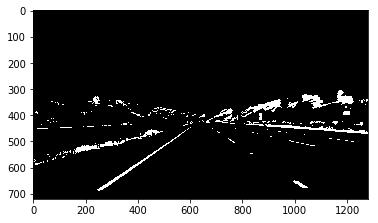

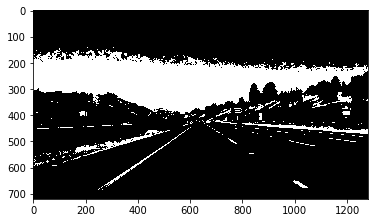

In [360]:
def apply_color_threshold(img, thresh=(0, 255)):
    color_thresh_img = np.zeros_like(img)
    color_thresh_img[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return color_thresh_img
image = cv2.imread(get_images(test_images_path)[0])
r_img, g_img, b_img = image[:,:,2], image[:,:,1], image[:,:,0]
hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
h_img, l_img, s_img = hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]
r_thresholded = apply_color_threshold(r_img, thresh=(175, 255))
l_thresholded = apply_color_threshold(l_img, thresh=(150, 255))
# plt.imshow(r_img)
# plt.show()
plt.imshow(r_thresholded, cmap="gray")
plt.show()
# plt.imshow(l_img)
# plt.show()
plt.imshow(l_thresholded, cmap="gray")
plt.show()

### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

### Step 5: Detect lane pixels and fit to find the lane boundary

### Step 6: Determine the curvature of the lane and vehicle position with respect to center

### Step 7: Warp the detected lane boundaries back onto the original image

### Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### Main module